<a href="https://colab.research.google.com/github/dgiri4132/QuantRiskEngine/blob/main/QuantRiskEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyPortfolioOpt
!pip install tensorflow-probability



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 19.6 MB/s eta 0:00:00


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
n=int(input('Enter the number of stocks: '))
tickers = [input(f"Enter ticker {i+1}: ").upper().strip() for i in range(n)]
start_date=input('Enter start date (YYYY-MM-DD): ')
end_date=input('Enter end date (YYYY-MM-DD): ')
df=yf.download(tickers,start=start_date,end=end_date, auto_adjust=False)['Adj Close'].dropna()
returns=df.pct_change().dropna()

Enter the number of stocks: 5
Enter ticker 1: amzn
Enter ticker 2: nvda
Enter ticker 3: aapl
Enter ticker 4: axp
Enter ticker 5: googl
Enter start date (YYYY-MM-DD): 2024-11-03
Enter end date (YYYY-MM-DD): 2025-06-11


[*********************100%***********************]  5 of 5 completed


In [17]:
#First Major Risk Metric(VaR)
from scipy.stats import norm
from scipy.stats import t
portfolio_returns=returns.mean(axis=1)
confidence_level=0.95
alpha=1-confidence_level
historical_VaR=np.quantile(portfolio_returns,alpha)
print(f'Historical VaR(95%): {historical_VaR:.4f}')
mean_p=portfolio_returns.mean()
std_p=portfolio_returns.std()
param_VaR=norm.ppf(alpha,mean_p,std_p)
print(f'Parametric VaR (Normal, 95%): {param_VaR:.4f}')
params_t=t.fit(portfolio_returns)
t_VaR=t.ppf(alpha,*params_t)
print(f'Parametric VaR (t-test,95%): {t_VaR:.4f}')

Historical VaR(95%): -0.0318
Parametric VaR (Normal, 95%): -0.0350
Parametric VaR (t-test,95%): -0.0294


In [18]:
#CVaR metrics
from scipy.stats import norm,t
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.expected_returns import mean_historical_return
historical_CVaR=portfolio_returns[portfolio_returns<=historical_VaR].mean()
print(f'Historical CVaR(95%): {historical_CVaR:.4f}')
param_CVaR=(1/alpha)*norm.expect(lambda x:x,loc=mean_p,scale=std_p,lb=-np.inf,ub=param_VaR)
print(f'Parametric CVaR(Normal,95%): {param_CVaR:.4f}')
df, loc,scale=params_t
t_CVaR=(1/alpha)*t.expect(lambda x:x, args=(df,), loc=loc,scale=scale,lb=-np.inf,ub=t_VaR)
print(f'Parametric CVaR(t-test,95%): {t_CVaR:.4f}')
mu=mean_historical_return(returns)
ec=EfficientCVaR(expected_returns=mu,returns=returns)
optimal_weight_efCVaR=ec.min_cvar()
print('Efficient CVaR Optimal weights(PyPortfolioOpt):')
for ticker, weight in optimal_weight_efCVaR.items():
  print(f'{ticker}: {weight:.4f}')

Historical CVaR(95%): -0.0460
Parametric CVaR(Normal,95%): -0.0441
Parametric CVaR(t-test,95%): -0.0492
Efficient CVaR Optimal weights(PyPortfolioOpt):
AAPL: 0.2573
AMZN: 0.1190
AXP: 0.0416
GOOGL: 0.4694
NVDA: 0.1128


/usr/local/lib/python3.11/dist-packages/pypfopt/expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:56: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


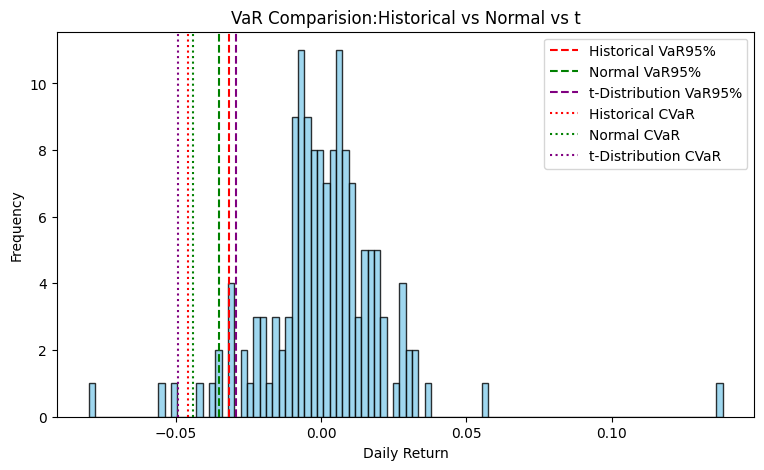

In [20]:
#Plots of all six VaR metrics
plt.figure(figsize=(9,5))
plt.hist(portfolio_returns,bins=100,color='skyblue',alpha=0.8, edgecolor='black')
plt.axvline(historical_VaR,color='red',linestyle='--',label='Historical VaR95%')
plt.axvline(param_VaR,color='green',linestyle='--',label='Normal VaR95%')
plt.axvline(t_VaR,color='purple',linestyle='--',label='t-Distribution VaR95%')
plt.axvline(historical_CVaR, color='red', linestyle=':', label='Historical CVaR')
plt.axvline(param_CVaR, color='green', linestyle=':', label='Normal CVaR')
plt.axvline(t_CVaR, color='purple', linestyle=':', label='t-Distribution CVaR')
plt.title('VaR Comparision:Historical vs Normal vs t')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [21]:
#Monte Carlo simulation experiment
from scipy.stats import norm
import numpy as np
mu=portfolio_returns.mean()
sigma=portfolio_returns.std()
total_steps=390*60
N=int(input('Enter the number of simulations(more is better but longer time to process): '))
simulated_daily_returns=np.zeros(N)
for i in range(N):
  indp_path=norm.rvs(loc=mu/total_steps,scale=sigma/np.sqrt(total_steps),size=total_steps)
  simulated_daily_returns[i]=indp_path.sum()
alpha=0.05
mc_VaR=np.quantile(simulated_daily_returns,alpha)
print(f'Monte Carlo VaR(95%): {mc_VaR:.4f}')
mc_CVaR=np.mean(simulated_daily_returns[simulated_daily_returns<=mc_VaR])
print(f'Monte Carlo CVaR(95%): {mc_CVaR:.4f}')


Enter the number of simulations(more is better but longer time to process): 5000
Monte Carlo VaR(95%): -0.0353
Monte Carlo CVaR(95%): -0.0442


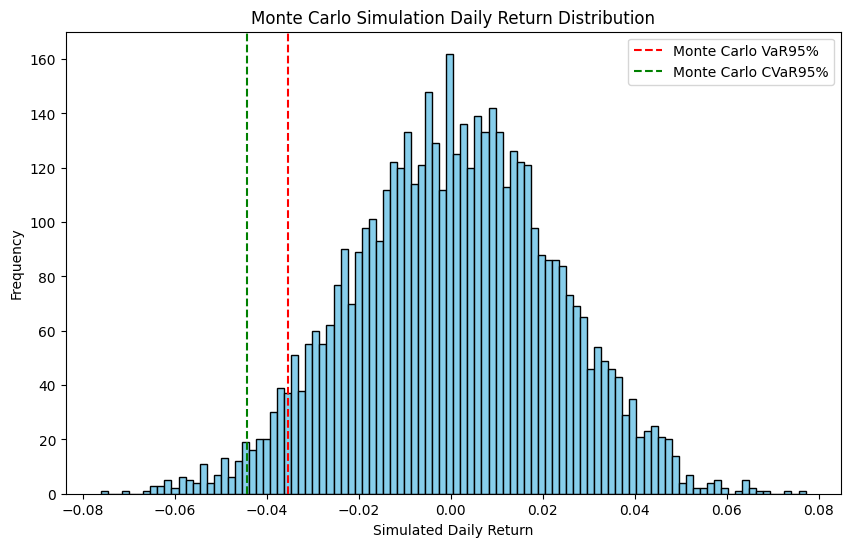

In [22]:
#Monte-Carlo visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(simulated_daily_returns,bins=100,color='skyblue',edgecolor='black')
plt.axvline(mc_VaR,color='red',linestyle='--',label='Monte Carlo VaR95%')
plt.axvline(mc_CVaR,color='green',linestyle='--',label='Monte Carlo CVaR95%')
plt.title('Monte Carlo Simulation Daily Return Distribution')
plt.xlabel('Simulated Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [28]:
#Extreme Value Theory(Block Maxima and Generalized Extreme Value Distribution)
from scipy.stats import genextreme
weekly_maxima=portfolio_returns.resample('W').min()
gev_params=genextreme.fit(weekly_maxima)
confidence_level=float(input('Enter the confidence level(normally assumed to be 0.95): '))
alpha=1-confidence_level
shape,loc,scale=gev_params
VaR_99_evt=genextreme.ppf(alpha,c=shape,loc=loc,scale=scale)
CVaR_99_evt=(1/alpha)*genextreme.expect(lambda x:x,args=(shape,),loc=loc,scale=scale,lb=-np.inf,ub=VaR_99_evt)
print(f'EVT-based VaR({confidence_level*100}): {VaR_99_evt:.4f}')
print(f'EVT-based CVaR({confidence_level*100}): {CVaR_99_evt:.4f}')

Enter the confidence level(normally assumed to be 0.95): 0.98
EVT-based VaR(98.0): -0.0628
EVT-based CVaR(98.0): -0.0733


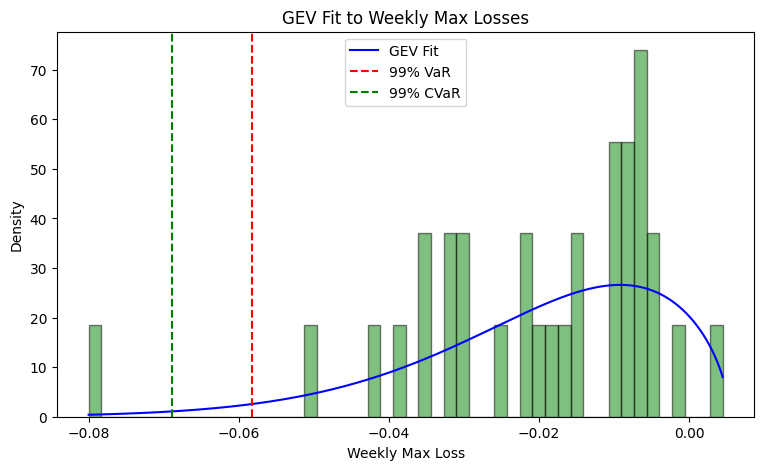

In [24]:
#GEV visualization
import matplotlib.pyplot as plt
import numpy as np
x_vals=np.linspace(min(weekly_maxima),max(weekly_maxima),1000)
gev_pdf=genextreme.pdf(x_vals,*gev_params)
plt.figure(figsize=(9,5))
plt.plot(x_vals,gev_pdf,label='GEV Fit',color='blue')
plt.axvline(VaR_99_evt,color='red',linestyle='--',label='99% VaR')
plt.axvline(CVaR_99_evt,color='green',linestyle='--',label='99% CVaR')
plt.hist(weekly_maxima,bins=50,density=True,alpha=0.5,color='green',edgecolor='black')
plt.title('GEV Fit to Weekly Max Losses')
plt.xlabel('Weekly Max Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

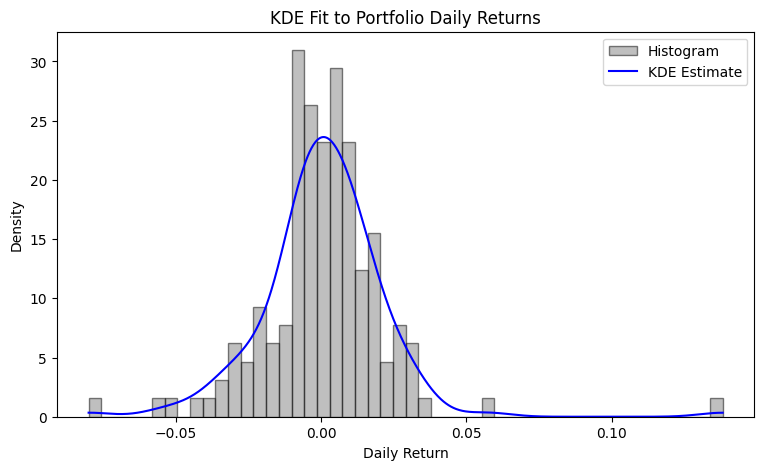

In [25]:
#Kernel-Density Estimation and Visualization
from scipy.stats import gaussian_kde
kde=gaussian_kde(portfolio_returns)
x_vals=np.linspace(min(portfolio_returns),max(portfolio_returns),1000)
pdf_vals=kde(x_vals)
plt.figure(figsize=(9,5))
plt.hist(portfolio_returns,bins=50,density=True,alpha=0.5,color='gray',edgecolor='black',label='Histogram')
plt.plot(x_vals,pdf_vals,color='blue',label='KDE Estimate')
plt.title('KDE Fit to Portfolio Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
#Neural Network
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
print('Select POrtfolio Objective: ')
print('1. Minimum Volatility')
print('2. Maximum Return')
print('3. Maximum Sharpe Ratio')
print('4 Minimize CVaR (95%)')
objective=int(input('Please Enter the number that you have as your choice: '))
def get_loss_function(objective,X_real,alpha=0.05):
  def port_variance_loss(y_true,weights):
    port_returns=tf.reduce_sum(y_true*weights,axis=1)
    return tf.math.reduce_variance(port_returns)
  def negative_return_loss(y_true,weights):
    port_returns=tf.reduce_sum(y_true*weights,axis=1)
    return -tf.reduce_mean(port_returns)
  def negative_sharpe_loss(y_true,weights):
    port_returns=tf.reduce_sum(y_true*weights,axis=1)
    mean=tf.reduce_mean(port_returns)
    std=tf.math.reduce_std(port_returns)
    return -mean/(std+1e-6)#I did this as it returned NaN which disrupted the training so added a small number
  def cvar_loss(y_true,weights):
    port_returns=tf.reduce_sum(y_true*weights,axis=1)
    losses=-port_returns
    var=tfp.stats.percentile(losses,q=alpha*100)
    tail=tf.boolean_mask(losses,losses>=var)
    return tf.reduce_mean(tail)
  if objective==1:
    return port_variance_loss
  elif objective==2:
    return negative_return_loss
  elif objective==3:
    return negative_sharpe_loss
  elif objective==4:
    return cvar_loss
  else:
    raise ValueError('Invalid choice.Must be 1-4')
X_real=tf.convert_to_tensor(returns.values,dtype=tf.float32)
n_assets=returns.shape[1]
loss_fn=get_loss_function(objective,X_real)
model = tf.keras.Sequential([tf.keras.Input(shape=(n_assets,)),tf.keras.layers.Dense(units=n_assets, activation='softmax')])
model.compile(optimizer='adam',loss=loss_fn)
model.fit(X_real,X_real,epochs=500,verbose=0)
optimal_weights=model.predict(X_real[:1])[0]
print('Neural Network POrtfolio Weights: ')
for name,weight in zip(returns.columns,optimal_weights):
  print(f'{name}:{weight:.4f}')

Select POrtfolio Objective: 
1. Minimum Volatility
2. Maximum Return
3. Maximum Sharpe Ratio
4 Minimize CVaR (95%)
Please Enter the number that you have as your choice: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Neural Network POrtfolio Weights: 
AAPL:0.0722
AMZN:0.1438
AXP:0.2192
GOOGL:0.1675
NVDA:0.3973


/usr/local/lib/python3.11/dist-packages/pypfopt/expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:56: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
[*********************100%***********************]  1 of 1 completed


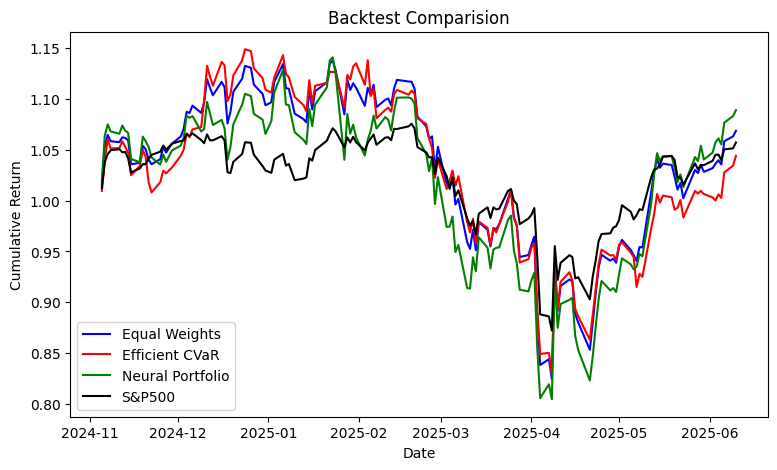

In [27]:
#Backtest Comparision and visualitzaion
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
import yfinance as yf
equal_weights=np.ones(n_assets)/n_assets
nn_weights=optimal_weights
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
mu=mean_historical_return(returns)
ec=EfficientCVaR(mu,returns=returns)
optimal_weights_ef_CVaR=list(ec.min_cvar().values())
equal_w_portfolio=returns @ equal_weights
efficientCVaR_portfolio_returns=returns @ optimal_weights_ef_CVaR
neural_portfolio_returns=returns @ nn_weights
equal_cum=(1+equal_w_portfolio).cumprod()
efficient_cum=(1+efficientCVaR_portfolio_returns).cumprod()
neural_cum=(1+neural_portfolio_returns).cumprod()
sp_500=yf.download('^GSPC',start=start_date,end=end_date,auto_adjust=False)['Adj Close']
sp_500_returns=sp_500.pct_change().dropna()
sp_500_cum=(1+sp_500_returns).cumprod()
plt.figure(figsize=(9,5))
plt.plot(equal_cum,label='Equal Weights',color='blue')
plt.plot(efficient_cum, label='Efficient CVaR', color='red')
plt.plot(neural_cum, label='Neural Portfolio',color='green')
plt.plot(sp_500_cum,label='S&P500',color='black')
plt.title('Backtest Comparision')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()